# Mercedes F1 Race Strategy Predictor & Competitor Analysis

This notebook implements a Mercedes F1 race strategy predictor using historical data and machine learning techniques, focusing mainly on Lewis Hamilton's race strategy, and comparing it to Max Verstappen's race strategy. The predictor analyzes past race performances, tire degradation patterns, and environmental factors to simulate optimal pit stop strategies for drivers. As well as that, we analyse sector times for both drivers at the Bahrain circuit, to see where Lewis Hamilton can improve to match Verstappen's performance.

## Libraries and Dependencies

- **Data Manipulation**: `pandas`, `numpy`
- **Machine Learning**: `sklearn` (preprocessing, linear models)
- **Data Visualization**: `matplotlib`
- **Statistical Analysis**: `scipy.stats`
- **F1 Data Access**: `fastf1`
- **Utility**: `itertools`, `datetime`

## Key Features

1. Historical data extraction for specific tracks and years
2. Tire compound performance analysis
3. Weather impact assessment on race strategy
4. Machine learning-based lap time prediction
5. Multi-stop strategy simulation and optimization
6. Comparative analysis between drivers (focused on Hamilton and Verstappen)
7. Real-time race simulation using dynamic weather inputs

The notebook leverages the `fastf1` library to access official Formula 1 data, employs `sklearn` for machine learning models, and utilizes `matplotlib` for visualizing race strategies and performance comparisons.

## Limitations and Considerations

1. **API Constraints**: Due to limitations in the available API data, real-time weather information is simulated using array inputs rather than live data feeds.
2. **Historical Data Dependency**: The model's accuracy is contingent on the quality and quantity of historical data available for each track and driver.
3. **Simplified Weather Model**: The weather impact on race strategy is modeled using basic parameters and may not capture all real-world complexities.
4. **Static Pit Stop Times**: The model assumes consistent pit stop durations, which may not reflect race-day variations due to unforeseen circumstances.
5. **Limited Team Strategy Considerations**: The predictor primarily focuses on tire strategy and does not fully incorporate team-specific tactical decisions, due to the lack of public data on team strategies.
6. **Race Strategy Focus**: This notebook primarily concentrates on race day strategy, excluding detailed analysis of practice sessions, sprint races, and qualifying. This focus is due to limitations in contextual data availability from the API for non-race sessions. While these other sessions can influence race strategy, the model assumes their effects are indirectly captured in the race day performance data.

Despite these limitations, this notebook provides a comprehensive framework for analyzing and predicting F1 race strategies, offering valuable insights into the complex decision-making process in Formula 1 racing.

In [ ]:
import fastf1 as ff1
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from itertools import permutations
import datetime

import matplotlib.pyplot as plt
from scipy.stats import norm


For this demonstration, we will use the historical data of the Bahrain Grand Prix from the last three years (2022-2024). This period represents the new era of Formula 1 regulations, providing the most relevant data to determine the ideal strategy for the upcoming race at the Bahrain International Circuit.

### Key Points:

1. **Data Range**: The years 2022-2024 are selected to focus on the most recent and relevant race data.
2. **Track Focus**: Bahrain is chosen as the target track for our strategy prediction.


By concentrating on these recent years, we ensure that our strategy predictions are based on current car designs and regulations, which underwent significant changes in 2022. This approach provides the most accurate and applicable insights for upcoming races at the Bahrain circuit.

In [2]:
# Enable cache
# ff1.Cache.enable_cache('cache')

# Define the years and track
years = [2022, 2023, 2024]
track = 'Bahrain'

## Data Collection

Collecting the lap data for Lewis Hamilton and Max Verstappen from the Bahrain Grand Prix for the years 2022-2024, as well as the weather data.

In [ ]:
hamilton_data_list = []
verstappen_data_list = []

# Collect data for each year
for year in years:
    # Load the race session
    race = ff1.get_session(year, track, 'R')
    race.load(laps=True, weather=True)
    
    # Extract Hamilton's lap data
    hamilton_race = race.laps.pick_driver(
        'HAM')
    # Extract Verstappen's lap data
    verstappen_race = race.laps.pick_driver(
        'VER')
    
    # Extract weather data
    weather_data = race.weather_data
    
    # Reset index to ensure proper alignment
    hamilton_race = hamilton_race.reset_index(drop=True)
    verstappen_race = verstappen_race.reset_index(drop=True)
    weather_data = weather_data.reset_index(drop=True)
    
    # Merge weather data with Hamilton's lap data
    combined_data = hamilton_race.join(weather_data.loc[:, ~(weather_data.columns == 'Time')])
    combined_data_verstappen = verstappen_race.join(weather_data.loc[:, ~(weather_data.columns == 'Time')])
    # Append the combined data to the list
    hamilton_data_list.append(combined_data)
    verstappen_data_list.append(combined_data_verstappen)

In [4]:
# Sample of stats for 2022 Bahrain Grand Prix for Hamilton
hamilton_data_list[0].head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,DeletedReason,FastF1Generated,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 01:04:16.741000,HAM,44,0 days 00:01:41.555000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:42.966000,...,,False,False,25.6,17.0,1010.2,False,32.3,346,0.5
1,0 days 01:05:55.743000,HAM,44,0 days 00:01:39.002000,2.0,1.0,NaT,NaT,0 days 00:00:31.844000,0 days 00:00:42.722000,...,,False,True,25.7,17.0,1010.2,False,32.3,347,0.6
2,0 days 01:07:34.818000,HAM,44,0 days 00:01:39.075000,3.0,1.0,NaT,NaT,0 days 00:00:31.671000,0 days 00:00:42.931000,...,,False,True,25.7,17.0,1010.0,False,32.2,359,0.4
3,0 days 01:09:13.710000,HAM,44,0 days 00:01:38.892000,4.0,1.0,NaT,NaT,0 days 00:00:31.388000,0 days 00:00:42.990000,...,,False,True,25.7,17.0,1010.2,False,32.2,8,0.4
4,0 days 01:10:52.633000,HAM,44,0 days 00:01:38.923000,5.0,1.0,NaT,NaT,0 days 00:00:31.550000,0 days 00:00:42.893000,...,,False,True,25.6,17.0,1010.0,False,32.1,16,0.5


In [5]:
# Sample of stats for 2022 Bahrain Grand Prix for Verstappen
verstappen_data_list[0].head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,DeletedReason,FastF1Generated,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 01:04:15.422000,VER,1,0 days 00:01:40.236000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:42.325000,...,,False,False,25.6,17.0,1010.2,False,32.3,346,0.5
1,0 days 01:05:53.302000,VER,1,0 days 00:01:37.880000,2.0,1.0,NaT,NaT,0 days 00:00:31.285000,0 days 00:00:42.269000,...,,False,True,25.7,17.0,1010.2,False,32.3,347,0.6
2,0 days 01:07:31.659000,VER,1,0 days 00:01:38.357000,3.0,1.0,NaT,NaT,0 days 00:00:31.499000,0 days 00:00:42.474000,...,,False,True,25.7,17.0,1010.0,False,32.2,359,0.4
3,0 days 01:09:10.225000,VER,1,0 days 00:01:38.566000,4.0,1.0,NaT,NaT,0 days 00:00:31.342000,0 days 00:00:42.674000,...,,False,True,25.7,17.0,1010.2,False,32.2,8,0.4
4,0 days 01:10:49.102000,VER,1,0 days 00:01:38.877000,5.0,1.0,NaT,NaT,0 days 00:00:31.498000,0 days 00:00:42.854000,...,,False,True,25.6,17.0,1010.0,False,32.1,16,0.5


## Data Preprocessing

1. `preprocess_lap_data()`: Cleans and converts time columns, calculates average sector times.
2. `calculate_pit_stop_durations()`: Computes pit stop durations.
3. `calculate_tire_wear()`: Estimates tire wear rates for each stint based on lap time deltas.
4. `process_driver_data()`: Applies the above functions to a list of lap data DataFrames.

In [ ]:
def preprocess_lap_data(laps, time_columns=['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']):
    """
    Preprocess lap data by cleaning and converting time columns.
    """
    if laps is None or laps.empty:
        return pd.DataFrame()
        
    # Create a copy to avoid modifying original data
    laps = laps.copy()
    
    # Convert time columns to timedelta if they're strings
    for col in time_columns:
        if col in laps.columns:
            laps[col] = pd.to_timedelta(laps[col], errors='coerce')
    
    # Drop rows with missing critical data
    laps = laps.dropna(subset=time_columns)
    
    # Calculate average sector time in seconds
    laps['AvgSectorTime'] = (
        laps['Sector1Time'].dt.total_seconds() + 
        laps['Sector2Time'].dt.total_seconds() + 
        laps['Sector3Time'].dt.total_seconds()
    ) / 3
    
    return laps

def calculate_pit_stop_durations(laps):
    """
    Calculate pit stop durations
    """
    if laps is None or laps.empty:
        return 0.0
        
    laps = laps.copy()
    
    # Convert pit times to datetime if they're not already
    for col in ['PitInTime', 'PitOutTime']:
        if col in laps.columns:
            laps[col] = pd.to_datetime(laps[col], errors='coerce')
    
    # Calculate pit stop duration
    mask = ~laps['PitInTime'].isna() & ~laps['PitOutTime'].isna()
    laps['PitStopDuration'] = np.where(
        mask,
        (laps['PitOutTime'] - laps['PitInTime']).dt.total_seconds(),
        0
    )
    
    # Calculate average duration of actual pit stops
    average_pit_stop_duration = laps[laps['PitStopDuration'] > 0]['PitStopDuration'].mean()
    return average_pit_stop_duration if not pd.isna(average_pit_stop_duration) else 0.0

def calculate_tire_wear(laps):
    """
    Calculate tire wear rates for each stint.
    """
    if laps is None or laps.empty:
        return pd.DataFrame()
        
    laps = laps.copy()
    
    # Convert LapTime to seconds if it's not already
    if 'LapTime' in laps.columns:
        if isinstance(laps['LapTime'].iloc[0], str):
            laps['LapTime'] = pd.to_timedelta(laps['LapTime'], errors='coerce')
        laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
    
    # Ensure LapNumber is numeric
    laps['LapNumber'] = pd.to_numeric(laps['LapNumber'], errors='coerce')
    
    # Calculate lap time differences in seconds
    laps['LapTimeDelta'] = laps['LapTimeSeconds'].diff().fillna(0)
    
    # Calculate lap number differences
    lap_number_diff = laps['LapNumber'].diff().fillna(1)
    
    # Calculate tire wear rate (seconds per lap)
    laps['TireWearRate'] = np.where(
        lap_number_diff > 0,
        laps['LapTimeDelta'] / lap_number_diff,
        0
    )
    
    # Calculate average tire wear per lap for each stint
    if 'Stint' in laps.columns:
        laps['AvgTireWearPerLap'] = laps.groupby('Stint')['TireWearRate'].transform('mean')
    
    laps['TireWearRate'] = np.where(
        lap_number_diff > 0,
        laps['LapTimeDelta'] / lap_number_diff,
        0
    )
    # Ensure no negative wear rates
    laps['TireWearRate'] = laps['TireWearRate'].clip(lower=0)
    
    # Calculate average tire wear per lap for each stint
    if 'Stint' in laps.columns:
        laps['AvgTireWearPerLap'] = laps.groupby('Stint')['TireWearRate'].transform('mean')

    
    return laps

def process_driver_data(data_list):
    """
    Process a list of lap data DataFrames for a driver.
    """
    processed_data = []
    
    for data in data_list:
        try:
            # Apply preprocessing
            processed_laps = preprocess_lap_data(data)
            if not processed_laps.empty:
                # Calculate tire wear
                processed_laps = calculate_tire_wear(processed_laps)
                processed_data.append(processed_laps)
        except Exception as e:
            print(f"Error processing data: {str(e)}")
            continue
    
    return processed_data

# Process the data
processed_data_hamilton = process_driver_data(hamilton_data_list)
processed_data_verstappen = process_driver_data(verstappen_data_list)

### Time Data Formatting and Structure Improvement

This section defines functions to standardize and improve the structure of time-related data in our dataset.



1. `format_timedelta(td)`: 
   - Converts timedelta objects to a standardized string format (MM:SS.mmm).
   - Handles cases where the input is already a string.

2. `improve_time_structure(laps)`:
   - Applies the `preprocess_lap_data()` function to standardize time-related columns.

The `improve_time_structure()` function is applied to each DataFrame in both Hamilton's and Verstappen's processed data lists. This ensures that all time-related data is consistently formatted and structured across all race sessions for both drivers.

This standardization is crucial for accurate comparisons and analyses in subsequent parts of the notebook, particularly when examining lap times, sector times, and other time-based metrics.


In [7]:
# Function to format timedelta to string
def format_timedelta(td):
    """
    Format timedelta to string
    """
    # Check if the input is already a string
    if isinstance(td, str):
        return td  # Return as is if it's already a string

    total_seconds = int(td.total_seconds())
    minutes = total_seconds // 60
    seconds = total_seconds % 60
    milliseconds = int(td.microseconds / 1000)
    return f"{minutes}:{seconds:02}.{milliseconds:03}"

def improve_time_structure(laps):
    """
    Preprocess lap data
    """
    laps = preprocess_lap_data(laps)
    
    return laps

# Apply the function to each DataFrame in the list
processed_data_hamilton = [improve_time_structure(data) for data in processed_data_hamilton]
processed_data_verstappen = [improve_time_structure(data) for data in processed_data_verstappen]

In [8]:
# Extract Essential Data

essential_columns = [
    'LapTime', 'LapNumber', 'Stint', 'Compound', 'TyreLife', 'FreshTyre',
    'AirTemp', 'TrackTemp', 'Rainfall', 'AvgSectorTime', 'TireWearRate', 'AvgTireWearPerLap', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'PitOutTime', 'PitInTime'
]

# Initialize a list to store the essential data for each driver
hamilton_essential_data_list = []
verstappen_essential_data_list = []

def extract_essential_data(processed_data, essential_columns):
    """
    Extract essential data from processed data
    """
    essential_data_list = []
    for race_data in processed_data:
        # Select only the essential columns
        essential_data = race_data[essential_columns]
        # Append the essential data to the new list
        essential_data_list.append(essential_data)
    return essential_data_list

hamilton_essential_data_list = extract_essential_data(processed_data_hamilton, essential_columns)
verstappen_essential_data_list = extract_essential_data(processed_data_verstappen, essential_columns)

In [9]:
hamilton_essential_data_list[0].head()

,LapTime,LapNumber,Stint,Compound,TyreLife,FreshTyre,AirTemp,TrackTemp,Rainfall,AvgSectorTime,TireWearRate,AvgTireWearPerLap,Sector1Time,Sector2Time,Sector3Time,PitOutTime,PitInTime
1,0 days 00:01:39.002000,2.0,1.0,SOFT,4.0,False,25.7,32.3,False,33.000667,0.000,0.4151,0 days 00:00:31.844000,0 days 00:00:42.722000,0 days 00:00:24.436000,NaT,NaT
2,0 days 00:01:39.075000,3.0,1.0,SOFT,5.0,False,25.7,32.2,False,33.025000,0.073,0.4151,0 days 00:00:31.671000,0 days 00:00:42.931000,0 days 00:00:24.473000,NaT,NaT
3,0 days 00:01:38.892000,4.0,1.0,SOFT,6.0,False,25.7,32.2,False,32.964000,0.000,0.4151,0 days 00:00:31.388000,0 days 00:00:42.990000,0 days 00:00:24.514000,NaT,NaT
4,0 days 00:01:38.923000,5.0,1.0,SOFT,7.0,False,25.6,32.1,False,32.974333,0.031,0.4151,0 days 00:00:31.550000,0 days 00:00:42.893000,0 days 00:00:24.480000,NaT,NaT
5,0 days 00:01:39.707000,6.0,1.0,SOFT,8.0,False,25.5,32.1,False,33.235667,0.784,0.4151,0 days 00:00:31.624000,0 days 00:00:43.248000,0 days 00:00:24.835000,NaT,NaT


In [10]:
verstappen_essential_data_list[0].head()

,LapTime,LapNumber,Stint,Compound,TyreLife,FreshTyre,AirTemp,TrackTemp,Rainfall,AvgSectorTime,TireWearRate,AvgTireWearPerLap,Sector1Time,Sector2Time,Sector3Time,PitOutTime,PitInTime
1,0 days 00:01:37.880000,2.0,1.0,SOFT,5.0,False,25.7,32.3,False,32.626667,0.000,0.326077,0 days 00:00:31.285000,0 days 00:00:42.269000,0 days 00:00:24.326000,NaT,NaT
2,0 days 00:01:38.357000,3.0,1.0,SOFT,6.0,False,25.7,32.2,False,32.785667,0.477,0.326077,0 days 00:00:31.499000,0 days 00:00:42.474000,0 days 00:00:24.384000,NaT,NaT
3,0 days 00:01:38.566000,4.0,1.0,SOFT,7.0,False,25.7,32.2,False,32.855333,0.209,0.326077,0 days 00:00:31.342000,0 days 00:00:42.674000,0 days 00:00:24.550000,NaT,NaT
4,0 days 00:01:38.877000,5.0,1.0,SOFT,8.0,False,25.6,32.1,False,32.959000,0.311,0.326077,0 days 00:00:31.498000,0 days 00:00:42.854000,0 days 00:00:24.525000,NaT,NaT
5,0 days 00:01:38.940000,6.0,1.0,SOFT,9.0,False,25.5,32.1,False,32.980000,0.063,0.326077,0 days 00:00:31.572000,0 days 00:00:42.759000,0 days 00:00:24.609000,NaT,NaT


### Pit Stop Time Analysis

This section calculates average pit stop times for Hamilton and Verstappen across multiple races. These averages provide insights into each driver's pit stop efficiency and team performance, which are crucial factors in race strategy planning.

These values will be used later to calculate the optimal pit stop strategy for the upcoming race.

In [12]:
# Initialize lists to store the average pit stop times for each DataFrame
hamilton_average_pit_stop_times = []
verstappen_average_pit_stop_times = []

def calculate_average_pit_stop_times(data_list):
    """
    Calculate average pit stop times for a list of drivers
    """
    average_pit_stop_times = []
    for df in data_list:
        valid_pit_durations = []
        for i in range(len(df) - 1):
            current_row = df.iloc[i]
            next_row = df.iloc[i + 1]
            if pd.notna(current_row['PitInTime']) and pd.notna(next_row['PitOutTime']):
                duration = (next_row['PitOutTime'] - current_row['PitInTime']).total_seconds()
                valid_pit_durations.append(duration)
        if valid_pit_durations:
            average_pit_stop_time = sum(valid_pit_durations) / len(valid_pit_durations)
            average_pit_stop_times.append(average_pit_stop_time)
    return average_pit_stop_times

# Calculate average pit stop times for Hamilton and Verstappen
hamilton_average_pit_stop_times = calculate_average_pit_stop_times(hamilton_essential_data_list)
verstappen_average_pit_stop_times = calculate_average_pit_stop_times(verstappen_essential_data_list)

# Calculate overall average pit stop times for both drivers across all races for the specific track
def overall_average(avg_times, driver_name):
    """
    Calculate overall average pit stop times for a driver across all races for the specific track
    """
    if avg_times:
        overall_average = sum(avg_times) / len(avg_times)
        print(f"{driver_name} Overall Average Pit Stop Time: {round(overall_average, 2)} seconds")
    else:
        print(f"No valid pit stop times found for {driver_name}.")

    return overall_average


hamilton_average_pit_stop_time = overall_average(hamilton_average_pit_stop_times, "Hamilton")
verstappen_average_pit_stop_time = overall_average(verstappen_average_pit_stop_times, "Verstappen")

Hamilton Overall Average Pit Stop Time: 24.93 seconds
Verstappen Overall Average Pit Stop Time: 24.67 seconds


### Advanced Data Processing and Year-Based Analysis

The below cell introduces more sophisticated data processing techniques and functions for year-based analysis of race data.

Functions include:

1. `preprocess_race_data()`: Processes a single race's data, adding year identifiers and calculating various metrics.
2. `process_yearly_races()`: Applies preprocessing to multiple years of race data, maintaining the year-based structure.
3. Helper functions for extracting and comparing data across different years.

This processing enables more detailed analysis of performance trends over time and facilitates easy comparison between different seasons.

In [13]:
def preprocess_race_data(data, year):
    """
    Preprocess a single race's data with year identifier
    """

    data = data.copy()
    
    # Add year identifier
    data['Year'] = year
    
    # Clean and process time columns
    time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
    for col in time_columns:
        if col in data.columns:
            data.loc[:, col] = pd.to_timedelta(data[col])
    
    # Calculate sector averages and lap time in seconds
    data.loc[:, 'AvgSectorTime'] = (
        data['Sector1Time'] + 
        data['Sector2Time'] + 
        data['Sector3Time']
    ) / 3
    
    data.loc[:, 'LapTimeSeconds'] = data['LapTime'].dt.total_seconds()
    
    # Calculate tire degradation within stints
    data.loc[:, 'TireDegradationRate'] = (
        data.groupby('Stint')['LapTimeSeconds'].diff() / 
        data['LapNumber'].diff().fillna(1)
    )
    
    # Add compound-specific metrics if available
    if 'Compound' in data.columns:
        data.loc[:, 'AvgPerformancePerCompound'] = (
            data.groupby('Compound')['LapTimeSeconds'].transform('mean')
        )
        
    return data

def process_yearly_races(race_data_list, years=[2022, 2023, 2024]):
    """
    Process races maintaining the year-based structure
    """
    processed_races = []
    
    # Process each year's race
    for i, (race_data, year) in enumerate(zip(race_data_list, years)):
        try:
            processed_race = preprocess_race_data(race_data, year)
            processed_races.append(processed_race)
        except Exception as e:
            print(f"Error processing {year} race data: {str(e)}")
            processed_races.append(pd.DataFrame())
    
    # Create combined dataset
    combined_data = pd.concat(processed_races, ignore_index=True)
    
    return processed_races, combined_data

# Helper functions for analysis
def get_year_data(data_list, year_index):
    """
    Get data for a specific year from the list
    """
    if 0 <= year_index < len(data_list):
        return data_list[year_index]
    return None

def get_year_from_combined(combined_data, year):
    """
    Get data for a specific year from combined dataset
    """
    return combined_data[combined_data['Year'] == year].copy()

def compare_years(data, metric='LapTimeSeconds'):
    """
    Compare a metric across different years
    """
    comparison = (data.groupby('Year')[metric]
                 .agg(['mean', 'min', 'max', 'std'])
                 .round(3))
    return comparison


hamilton_processed_races, hamilton_combined_data = process_yearly_races(hamilton_essential_data_list)
verstappen_processed_races, verstappen_combined_data = process_yearly_races(verstappen_essential_data_list)


In [14]:
# Remove unnecessary columns and handle missing values

hamilton_combined_data.drop(columns=['PitOutTime', 'PitInTime'], inplace=True)
hamilton_combined_data['TireDegradationRate'].fillna(0, inplace=True)

verstappen_combined_data.drop(columns=['PitOutTime', 'PitInTime'], inplace=True)
verstappen_combined_data['TireDegradationRate'].fillna(0, inplace=True)

In [15]:
# Define the columns that will be used to train the model

critical_columns = [
    'LapTimeSeconds', 'Compound', 'TyreLife', 'Stint', 'LapNumber',
    'TrackTemp', 'AirTemp', 'Rainfall',
    'Sector1Time', 'Sector2Time', 'Sector3Time', 'TireDegradationRate'
]

hamilton_df = hamilton_combined_data[critical_columns]
verstappen_df = verstappen_combined_data[critical_columns]

In [ ]:
# Convert sector times to seconds
hamilton_df.loc[:, 'Sector1Time'] = hamilton_df['Sector1Time'].dt.total_seconds()
hamilton_df.loc[:, 'Sector2Time'] = hamilton_df['Sector2Time'].dt.total_seconds()
hamilton_df.loc[:, 'Sector3Time'] = hamilton_df['Sector3Time'].dt.total_seconds()

verstappen_df.loc[:, 'Sector1Time'] = verstappen_df['Sector1Time'].dt.total_seconds()
verstappen_df.loc[:, 'Sector2Time'] = verstappen_df['Sector2Time'].dt.total_seconds()
verstappen_df.loc[:, 'Sector3Time'] = verstappen_df['Sector3Time'].dt.total_seconds()

In [17]:
hamilton_df.head()

,LapTimeSeconds,Compound,TyreLife,Stint,LapNumber,TrackTemp,AirTemp,Rainfall,Sector1Time,Sector2Time,Sector3Time,TireDegradationRate
0,99.002,SOFT,4.0,1.0,2.0,32.3,25.7,False,31.844,42.722,24.436,0.000
1,99.075,SOFT,5.0,1.0,3.0,32.2,25.7,False,31.671,42.931,24.473,0.073
2,98.892,SOFT,6.0,1.0,4.0,32.2,25.7,False,31.388,42.990,24.514,-0.183
3,98.923,SOFT,7.0,1.0,5.0,32.1,25.6,False,31.550,42.893,24.480,0.031
4,99.707,SOFT,8.0,1.0,6.0,32.1,25.5,False,31.624,43.248,24.835,0.784


In [18]:
verstappen_df.head()

,LapTimeSeconds,Compound,TyreLife,Stint,LapNumber,TrackTemp,AirTemp,Rainfall,Sector1Time,Sector2Time,Sector3Time,TireDegradationRate
0,97.880,SOFT,5.0,1.0,2.0,32.3,25.7,False,31.285,42.269,24.326,0.000
1,98.357,SOFT,6.0,1.0,3.0,32.2,25.7,False,31.499,42.474,24.384,0.477
2,98.566,SOFT,7.0,1.0,4.0,32.2,25.7,False,31.342,42.674,24.550,0.209
3,98.877,SOFT,8.0,1.0,5.0,32.1,25.6,False,31.498,42.854,24.525,0.311
4,98.940,SOFT,9.0,1.0,6.0,32.1,25.5,False,31.572,42.759,24.609,0.063


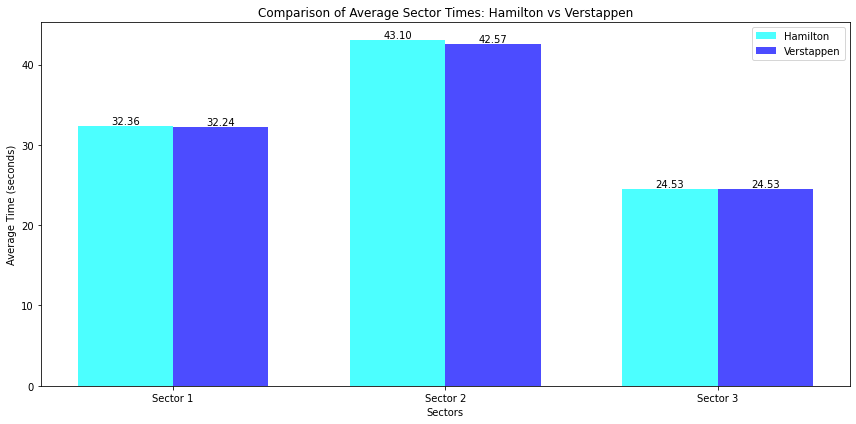

In [20]:
# Calculate average sector times for each driver
hamilton_avg_sectors = hamilton_df[['Sector1Time', 'Sector2Time', 'Sector3Time']].mean()
verstappen_avg_sectors = verstappen_df[['Sector1Time', 'Sector2Time', 'Sector3Time']].mean()

sectors = ['Sector 1', 'Sector 2', 'Sector 3']
hamilton_times = hamilton_avg_sectors.values
verstappen_times = verstappen_avg_sectors.values

plt.figure(figsize=(12, 6))
x = range(len(sectors))
width = 0.35

# Create grouped bar chart
plt.bar([i - width/2 for i in x], hamilton_times, width, label='Hamilton', color='cyan', alpha=0.7)
plt.bar([i + width/2 for i in x], verstappen_times, width, label='Verstappen', color='blue', alpha=0.7)


plt.xlabel('Sectors')
plt.ylabel('Average Time (seconds)')
plt.title('Comparison of Average Sector Times: Hamilton vs Verstappen')
plt.xticks(x, sectors)
plt.legend()

# Add value labels on top of each bar
for i, v in enumerate(hamilton_times):
    plt.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(verstappen_times):
    plt.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Sector Time Comparison: Hamilton vs Verstappen

| Sector | Hamilton (s) | Verstappen (s) | Difference (s) |
|--------|--------------|----------------|----------------|
| 1      | 32.36        | 32.24          | +0.12          |
| 2      | 43.10        | 42.57          | +0.53          |
| 3      | 24.53        | 24.53          |  0.00           |

<img src="bahrain.png" alt="Bahrain Circuit Sector Map" title="Bahrain International Circuit Sectors" width="300" />

#### Key Observations:

1. **Overall Advantage**: Verstappen is faster in two sectors, with a cumulative advantage of 0.65 seconds per lap.

2. **Sector 1**: Small difference (0.12s). This sector includes a long straight followed by a series of medium to high-speed corners, suggesting Red Bull has a slight advantage in straight-line speed and high-speed cornering.

3. **Sector 2**: Most significant difference (0.53s). This sector contains a mix of medium-speed corners and short straights, indicating Red Bull's car has superior handling and acceleration out of slower corners.

4. **Sector 3**: No discernible difference. This sector features a long straight followed by a few slow corners, suggesting Mercedes can match Red Bull's pace in a mix of straight-line speed and low-speed cornering.

5. **Performance Distribution**: Verstappen's advantage is concentrated in Sector 2, while the performance is closer in Sector 1 and identical in Sector 3 at this level of precision.

This sector analysis highlights Red Bull's current performance edge over Mercedes, particularly in areas that reward balanced aerodynamic efficiency, handling in medium-speed corners, and acceleration. The data also shows that Hamilton is able to match Verstappen's pace in the final sector, which combines straight-line speed with low-speed cornering ability.

## F1 Race Strategy Analyzer

This class implements a sophisticated model for predicting optimal race strategies in Formula 1, focusing on tire management and pit stop timing.

### Key Components:

1. **Physics-Based Polynomial Model**
   - Uses Ridge regression with polynomial features
   - Accounts for nonlinear tire degradation patterns
   - Features: Tire life, stint number, lap number, track/air temperature, and tire compound

2. **Tire Compound Performance Modeling**
   - Calculates compound-specific characteristics based on historical data
   - Considers base lap time, degradation rate, thermal sensitivity, and optimal usage range
   - Fallback mechanisms for missing or unreliable data

3. **Dynamic Strategy Simulation**
   - Generates realistic multi-stop strategies
   - Simulates lap times considering tire wear and changing track conditions
   - Validates strategies based on F1 regulations and tire life constraints

4. **Environmental Factors**
   - Incorporates track and air temperature effects on tire performance
   - Uses a dynamic track temperature model for race simulation

### Model Choice and Rationale:

1. **Ridge Regression with Polynomial Features**
   - Captures nonlinear relationships in tire degradation
   - Ridge penalty helps prevent overfitting, crucial for the limited dataset
   - Polynomial degree of 2 balances complexity and interpretability

2. **Physics-Based Approach**
   - Incorporates domain knowledge about tire behavior
   - Allows for more realistic predictions compared to purely statistical models

3. **Dynamic Strategy Generation**
   - Explores a wide range of possible strategies
   - Considers F1-specific rules (e.g., using at least two compounds)
   - Balances computational efficiency with strategy diversity

### Key Functions:

1. `setup_model()`: Initializes and trains the predictive model
2. `simulate_stint()`: Simulates lap times for a single stint
3. `generate_strategy_options()`: Creates realistic pit stop strategies
4. `simulate_multi_stop_strategy()`: Evaluates multiple strategies to find the optimal one

### Limitations and Considerations:

1. Relies on historical data quality and availability
2. Simplified modeling of complex factors like fuel load and track evolution due to lack of available data
3. Assumes consistent pit stop times, which may vary in real races
4. Does not account for race-specific factors like safety cars.

### Potential Improvements:

1. Incorporate more advanced machine learning models (e.g., neural networks)
2. Add real-time strategy adjustment capabilities (not possible with currently available data)
3. Include competitor modeling for more strategic decision-making
4. Enhance weather and track condition modeling 

This analyzer provides a comprehensive framework for F1 race strategy prediction, balancing theoretical models with practical constraints and historical data analysis.

In [21]:
class F1StrategyAnalyzer:
    def format_time(self, seconds):
        """
        Convert seconds to mm:ss.sss format
        """   
        if isinstance(seconds, list):
            return [self.format_time(s) for s in seconds]
        
        if seconds < 0:
            return f"-{self.format_time(abs(seconds))}"
        minutes = int(seconds // 60)
        remaining_seconds = seconds % 60
        return f"{minutes:02d}:{remaining_seconds:06.3f}"

    def format_total_race_time(self, seconds):
        """
        Convert seconds to 1hr 28mins 21.0s format
        """
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{hours}hr {minutes}mins {seconds:.1f}s"

    def __init__(self, data, driver_average_pit_stop_time):
        self.data = data.copy()
        self.model = None
        self.poly_transformer = None
        self.compound_encoder = LabelEncoder()
        self.PIT_STOP_TIME = driver_average_pit_stop_time
        
        print(f"Using average pit stop time of {self.format_time(self.PIT_STOP_TIME)} based on historical data")
        
        # Define tire life characteristics
        self.tire_life_ranges = {
            'SOFT': {'optimal': (4, 8), 'maximum': 15, 'base_advantage': -1.2},  
            'MEDIUM': {'optimal': (15, 25), 'maximum': 30, 'base_advantage': 0}, 
            'HARD': {'optimal': (20, 35), 'maximum': 40, 'base_advantage': 1.5},  
            'INTERMEDIATE': {'optimal': (15, 25), 'maximum': 30, 'base_advantage': 2.0},
            'WET': {'optimal': (15, 30), 'maximum': 35, 'base_advantage': 3.0}
        }

        self.setup_model()
        self.compound_performance = self._calculate_compound_performance()

    def setup_model(self):
        """
        Initialize and train physics-based polynomial model
        """
        # Encode compounds
        self.data['Compound_Encoded'] = self.compound_encoder.fit_transform(self.data['Compound'])
        
        # Create base features
        features = [
            'TyreLife', 
            'Stint',
            'LapNumber',
            'TrackTemp',
            'AirTemp',
            'Compound_Encoded'
        ]
        X = self.data[features]
        y = self.data['LapTimeSeconds']
        
        # Create polynomial features for nonlinear tire degradation
        self.poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = self.poly_transformer.fit_transform(X)
        
        # Use Ridge regression to prevent overfitting
        self.model = Ridge(alpha=1.0)
        self.model.fit(X_poly, y)

    def predict_lap_time(self, features):
        """
        Predict lap time using polynomial features
        """
        X_poly = self.poly_transformer.transform(features)
        return self.model.predict(X_poly)
    
    
    def _calculate_compound_performance(self):
        """
        Calculate physics-based performance characteristics for each compound
        """
        performance = {}
        
        # Get overall mean lap time as fallback
        overall_mean_laptime = self.data['LapTimeSeconds'].mean()
        
        for compound in self.data['Compound'].unique():
            compound_data = self.data[self.data['Compound'] == compound]
            
            # Calculate compound-specific characteristics
            base_advantage = self.tire_life_ranges[compound]['base_advantage']
            optimal_window = self.tire_life_ranges[compound]['optimal']
            
            # Calculate degradation rate based on compound type. Fallback values for missing data
            if compound == 'SOFT':
                thermal_sensitivity = 1.2
                base_offset = -1.0  # Softs are faster
            elif compound == 'MEDIUM':
                thermal_sensitivity = 1.0
                base_offset = 0.0  # Reference tire
            else:  # HARD
                thermal_sensitivity = 0.8
                base_offset = 1.0  # Hards are slower
            
            # Get degradation rate from driver_df
            deg_rate = self.data[self.data['Compound'] == compound]['TireDegradationRate'].mean()
            
            # Get empirical base performance with fallback
            valid_laps = compound_data[
                compound_data['TyreLife'].between(
                    optimal_window[0], optimal_window[1]
                )
            ]
            
            # Calculate base time, using fallback if no valid data
            if not valid_laps.empty:
                base_time = valid_laps['LapTimeSeconds'].mean()
            else:
                # Use overall mean with compound-specific offset
                base_time = overall_mean_laptime + base_offset
            
            performance[compound] = {
                'base_time': base_time,
                'base_advantage': base_advantage,
                'degradation_rate': deg_rate,
                'thermal_sensitivity': thermal_sensitivity,
                'optimal_range': optimal_window,
                'maximum_life': self.tire_life_ranges[compound]['maximum']
            }
            
            # Validate the base_time
            if performance[compound]['base_time'] is None or np.isnan(performance[compound]['base_time']):
                performance[compound]['base_time'] = overall_mean_laptime + base_offset
                
        return performance

    def get_compound_benchmarks(self):
        """
        Get realistic lap time benchmarks from data
        """
        benchmarks = {}
        for compound in self.data['Compound'].unique():
            compound_data = self.data[self.data['Compound'] == compound]
            if not compound_data.empty:
                # Get realistic lap time ranges
                valid_times = compound_data[
                    (compound_data['LapTimeSeconds'] >= 85) &  # Filter out outliers
                    (compound_data['LapTimeSeconds'] <= 100)
                ]['LapTimeSeconds']
                
                benchmarks[compound] = {
                    'fastest': valid_times.quantile(0.1), 
                    'average': valid_times.mean(),
                    'slowest': valid_times.quantile(0.9), 
                    'typical_deg': compound_data['TireDegradationRate'].mean()  # Get average degradation rate from data
                }
        return benchmarks

    def simulate_stint(self, compound, num_laps, track_temps, air_temp, start_lap):
        """
        Simulate lap times for a single stint
        """
        perf = self.compound_performance[compound]
        base_time = perf['base_time']
        deg_rate = perf['degradation_rate']
        
        lap_times = []
        for lap in range(num_laps):
            lap_time = base_time + (deg_rate * lap)
            
            # Apply temperature effect
            track_temp = track_temps[start_lap + lap]
            temp_delta = track_temp - 25
            temp_effect = perf['thermal_sensitivity'] * 0.01 * temp_delta if temp_delta > 0 else 0
            lap_time += temp_effect
            
            # Ensure lap time doesn't exceed a reasonable maximum
            max_time = base_time * 1.05  
            lap_time = min(lap_time, max_time)
            
            lap_times.append(lap_time)
        
        return lap_times

    def _calculate_compound_performance(self):
        """
        Calculate compound performance based on real data from self.data
        """
        performance = {}
        overall_mean_laptime = self.data['LapTimeSeconds'].mean()
        overall_deg_rate = self.data['TireDegradationRate'].mean()
        
        for compound in self.data['Compound'].unique():
            compound_data = self.data[self.data['Compound'] == compound]
            
            if not compound_data.empty:
                # Calculate base time (fastest lap time for this compound)
                base_time = compound_data['LapTimeSeconds'].min()
                
                # Calculate degradation rate
                compound_data = compound_data.sort_values(['Stint', 'LapNumber'])
                lap_time_diff = compound_data.groupby('Stint')['LapTimeSeconds'].diff()
                deg_rate = lap_time_diff[lap_time_diff > 0].mean()
                
                # Calculate thermal sensitivity
                thermal_sensitivity = compound_data['LapTimeSeconds'].corr(compound_data['TrackTemp'])
                
                # Get optimal range and maximum life from tire_life_ranges
                optimal_range = self.tire_life_ranges[compound]['optimal']
                maximum_life = self.tire_life_ranges[compound]['maximum']
                
                # Calculate average performance over optimal range
                optimal_performance = compound_data[
                    compound_data['TyreLife'].between(*optimal_range)
                ]['LapTimeSeconds'].mean()
                
                performance[compound] = {
                    'base_time': base_time,
                    'degradation_rate': deg_rate,
                    'thermal_sensitivity': 0.5,
                    'optimal_range': optimal_range,
                    'maximum_life': maximum_life,
                    'optimal_performance': base_time
                }
            else:
                print(f"Warning: No data available for {compound} compound. Using fallback values.")

                # Use fallback values for missing data
                base_time = overall_mean_laptime
                if compound == 'SOFT':
                    base_time -= 0.5  
                elif compound == 'HARD':
                    base_time += 0.5  
                performance[compound] = {
                    'base_time': self.data['LapTimeSeconds'].mean(),
                    'degradation_rate': overall_deg_rate * 1.5 if compound == 'SOFT' else overall_deg_rate * 0.75,
                    'thermal_sensitivity': 0.5,
                    'optimal_range': self.tire_life_ranges[compound]['optimal'],
                    'maximum_life': self.tire_life_ranges[compound]['maximum'],
                    'optimal_performance': self.data['LapTimeSeconds'].mean()
                }
            
            # Ensure all values are valid and print when using fallback
            for key, value in performance[compound].items():
                if pd.isna(value) or value is None:
                    print(f"Warning: Invalid {key} for {compound}. Using fallback value.")
                    if key in ['base_time', 'optimal_performance']:
                        performance[compound][key] = self.data['LapTimeSeconds'].mean()
                    elif key == 'degradation_rate':
                        performance[compound][key] = 0.1
                    elif key == 'thermal_sensitivity':
                        performance[compound][key] = 0.5
        
        return performance

    def generate_strategy_options(self, total_laps):
        """
        Generate realistic strategy options considering tire life and full race distance
        """
        options = []
        
        # One-stop strategies
        for first_stint in range(15, 30):
            remaining = total_laps - first_stint
            if 15 <= remaining <= self.tire_life_ranges['HARD']['maximum']:  # Use maximum of hardest tire
                options.append([first_stint])
        
        # Two-stop strategies
        for first_stint in range(12, 25):
            for second_stint in range(12, 25):
                remaining = total_laps - first_stint - second_stint
                if 12 <= remaining <= 25:
                    options.append([first_stint, first_stint + second_stint])
        
        # Filter options that don't cover full race distance
        return [opt for opt in options if (
            len(opt) == 1 and opt[0] < total_laps or
            len(opt) == 2 and opt[-1] < total_laps
        )]
    
    def calculate_stint_lengths(self, pit_laps, total_laps):
        """
        Calculate stint lengths from pit stop laps
        """
        stint_lengths = []
        previous_lap = 0
        
        # Calculate length of each stint up to the last pit stop
        for pit_lap in pit_laps:
            stint_lengths.append(pit_lap - previous_lap)
            previous_lap = pit_lap
        
        # Add final stint length (remaining laps)
        stint_lengths.append(total_laps - previous_lap)
        
        return stint_lengths

    def is_valid_strategy(self, compound_sequence, stint_lengths):
        """
        Enhanced strategy validation
        """
        if len(set(compound_sequence)) < 2:
            return False  # Must use at least 2 different compounds
        
        total_laps = sum(stint_lengths)
        if total_laps < 53:  # Ensure full race distance
            return False
            
        for compound, length in zip(compound_sequence, stint_lengths):
            if length > self.tire_life_ranges[compound]['maximum']:
                return False
                
            if length < self.tire_life_ranges[compound]['optimal'][0]:
                return False  # Stint too short
                
            if compound == 'SOFT' and length > self.tire_life_ranges['SOFT']['optimal'][1] + 5:
                return False
        
        return True

    def simulate_multi_stop_strategy(self, total_laps, conditions):
        compounds = list(self.data['Compound'].unique())
        best_strategy = None
        best_total_time = float('inf')
        
        strategy_options = self.generate_strategy_options(total_laps)
        
        # Generate dynamic track temperatures
        track_temps = conditions['track_temps']
        
        for num_stops in [1, 2]:
            for compound_sequence in permutations(compounds, num_stops + 1):
                for pit_laps in strategy_options:
                    if len(pit_laps) != num_stops:
                        continue
                        
                    stint_lengths = self.calculate_stint_lengths(pit_laps, total_laps)
                    
                    # Validate strategy
                    if not self.is_valid_strategy(compound_sequence, stint_lengths):
                        continue
                    
                    # Simulate valid strategy
                    total_time = 0
                    stints = []
                    current_lap = 1
                    valid_strategy = True
                    
                    for i, (compound, length) in enumerate(zip(compound_sequence, stint_lengths)):
                        stint_times = self.simulate_stint(
                            compound, length,
                            track_temps,
                            conditions['air_temp'],
                            current_lap
                        )
                        
                        if stint_times is None:
                            valid_strategy = False
                            break
                            
                        total_time += sum(stint_times)
                        if i < len(stint_lengths) - 1:
                            total_time += self.PIT_STOP_TIME
                            
                        stints.append({
                            'compound': compound,
                            'laps': length,
                            'start_lap': current_lap,
                            'times': {
                                'avg': np.mean(stint_times),
                                'min': np.min(stint_times),
                                'max': np.max(stint_times)
                            },
                            'degradation': {
                                'total': stint_times[-1] - stint_times[0],
                                'per_lap': (stint_times[-1] - stint_times[0]) / length
                            }
                        })
                        current_lap += length
                    
                    if valid_strategy and total_time < best_total_time:
                        best_total_time = total_time
                        best_strategy = {
                            'stints': stints,
                            'total_time': total_time,
                            'num_stops': num_stops,
                            'pit_laps': pit_laps
                        }
        
        return best_strategy
    
    def print_strategy_analysis(self, strategy):
        """
        Print detailed strategy analysis
        """
        print("\n=== Optimal Race Strategy Analysis ===")
        print(f"Total Race Time: {self.format_total_race_time(strategy['total_time'])}")
        print(f"Number of Pit Stops: {strategy['num_stops']}")
        print(f"Total Laps: {sum(stint['laps'] for stint in strategy['stints'])}")
        
        for i, stint in enumerate(strategy['stints'], 1):
            print(f"\nStint {i}:")
            print(f"Compound: {stint['compound']}")
            print(f"Laps: {stint['laps']} (Laps {stint['start_lap']}-{stint['start_lap']+stint['laps']-1})")
            print(f"Average Lap Time: {self.format_time(stint['times']['avg'])}")
            print(f"Fastest Lap: {self.format_time(stint['times']['min'])}")
            print(f"Slowest Lap: {self.format_time(stint['times']['max'])}")
            print(f"Average degradation per lap: {self.format_time(stint['degradation']['per_lap'])}")
            
            if i < len(strategy['stints']):
                print(f"\nPit Stop {i}:")
                print(f"After Lap: {stint['start_lap']+stint['laps']-1}")
                print(f"Change: {stint['compound']} → {strategy['stints'][i]['compound']}")
                print(f"Pit Stop Time: {round(self.PIT_STOP_TIME, 2)} seconds")


# Generate dynamic track temperatures
total_laps = 53
start_temp = 24
end_temp = 30
track_temps = {lap: start_temp + (end_temp - start_temp) * (lap - 1) / (total_laps - 1) for lap in range(1, total_laps + 1)}

# Conditions to be used in the simulation in place of real-time data as its not available
conditions = {
    'track_temps': track_temps,
    'air_temp': 20
}

### Simulatation Results + Competitor Analysis

In [22]:
print("Hamilton Strategy:")
hamilton_analyzer = F1StrategyAnalyzer(hamilton_df, hamilton_average_pit_stop_time)
hamilton_strategy = hamilton_analyzer.simulate_multi_stop_strategy(53, conditions)
hamilton_analyzer.print_strategy_analysis(hamilton_strategy)

Hamilton Strategy:
Using average pit stop time of 00:24.927 based on historical data

=== Optimal Race Strategy Analysis ===
Total Race Time: 1.0hr 28.0mins 21.1s
Number of Pit Stops: 1
Total Laps: 53

Stint 1:
Compound: MEDIUM
Laps: 15 (Laps 1-15)
Average Lap Time: 01:40.194
Fastest Lap: 01:36.660
Slowest Lap: 01:41.493
Average degradation per lap: 00:00.322

Pit Stop 1:
After Lap: 15
Change: MEDIUM → HARD
Pit Stop Time: 24.93 seconds

Stint 2:
Compound: HARD
Laps: 38 (Laps 16-53)
Average Lap Time: 01:39.295
Fastest Lap: 01:34.726
Slowest Lap: 01:39.458
Average degradation per lap: 00:00.125


#### Key Observations for Lewis Hamilton's Strategy

1. **One-Stop Strategy**: The model suggests a one-stop strategy is optimal, balancing speed and tire management.

2. **Compound Choice**: Starting on mediums provides early race pace compared to hard runners, while the switch to hards ensures longevity for the final two-thirds of the race.

3. **Tire Management**: The significant difference in degradation rates between compounds (0.322s vs 0.125s per lap) highlights the importance of tire choice and management around Bahrain.

4. **Pace Consistency**: Despite the long final stint, the average lap time on hards (1:39.295) is competitive with the shorter medium tire stint (1:40.194), showcasing the effectiveness of this strategy.

5. **Strategic Flexibility**: The early stop (lap 15) could provide opportunities for undercuts against competitors or allow for strategy adjustments if race conditions change.

In [23]:
print("Verstappen Strategy:") 

verstappen_analyzer = F1StrategyAnalyzer(verstappen_df, verstappen_average_pit_stop_time)
verstappen_strategy = verstappen_analyzer.simulate_multi_stop_strategy(53, conditions)
verstappen_analyzer.print_strategy_analysis(verstappen_strategy)

Verstappen Strategy:
Using average pit stop time of 00:24.669 based on historical data

=== Optimal Race Strategy Analysis ===
Total Race Time: 1.0hr 28.0mins 4.3s
Number of Pit Stops: 2
Total Laps: 53

Stint 1:
Compound: MEDIUM
Laps: 15 (Laps 1-15)
Average Lap Time: 01:39.249
Fastest Lap: 01:36.347
Slowest Lap: 01:41.164
Average degradation per lap: 00:00.321

Pit Stop 1:
After Lap: 15
Change: MEDIUM → SOFT
Pit Stop Time: 24.67 seconds

Stint 2:
Compound: SOFT
Laps: 13 (Laps 16-28)
Average Lap Time: 01:36.735
Fastest Lap: 01:32.612
Slowest Lap: 01:37.238
Average degradation per lap: 00:00.356

Pit Stop 2:
After Lap: 28
Change: SOFT → HARD
Pit Stop Time: 24.67 seconds

Stint 3:
Compound: HARD
Laps: 25 (Laps 29-53)
Average Lap Time: 01:39.546
Fastest Lap: 01:35.171
Slowest Lap: 01:39.918
Average degradation per lap: 00:00.190


#### Key Observations for Max Verstappen's Strategy

1. **Two-Stop Strategy**: Verstappen's optimal strategy involves two stops, contrasting with Hamilton's one-stop approach.

2. **Aggressive Middle Stint**: The use of soft tires for the middle stint is a bold move, potentially allowing Verstappen to gain a significant time advantage.

3. **Faster Overall Time**: Despite an extra pit stop, Verstappen's total race time is predicted to be about 17 seconds faster than Hamilton's.

4. **Compound Utilization**: This strategy makes use of all three main compound types, maximizing the advantages of each at different race stages.

5. **Higher Degradation**: The soft tire stint shows the highest degradation (0.356s/lap), but its shorter duration mitigates this risk.

6. **Strategic Flexibility**: The two-stop strategy provides more opportunities to react to changing race conditions or competitor strategies.

# Comparative Analysis: Hamilton vs. Verstappen Race Strategies

## Overview

| Metric                | Lewis Hamilton | Max Verstappen |
|-----------------------|-----------------|-----------------|
| Total Race Time       | 1:28:21.1       | 1:28:04.3       |
| Number of Pit Stops   | 1               | 2               |
| Fastest Lap           | 1:34.726 (Hard) | 1:32.612 (Soft) |

## Strategy Breakdown

### Pit Stop Approach
- **Hamilton**: One-stop strategy (Medium → Hard)
- **Verstappen**: Two-stop strategy (Medium → Soft → Hard)

### Tire Usage
- **Hamilton**: 
  - Medium: 15 laps
  - Hard: 38 laps
- **Verstappen**:
  - Medium: 15 laps
  - Soft: 13 laps
  - Hard: 25 laps

## Comparative Analysis

1. **Overall Pace**
   - Verstappen's strategy is predicted to be 16.8 seconds faster overall.
   - This aligns with Red Bull's current performance advantage over Mercedes.

2. **Strategic Approach**
   - Hamilton's one-stop strategy minimizes time lost in pit stops but requires more conservative tire management.
   - Verstappen's two-stop strategy allows for more aggressive driving, particularly in the middle stint on soft tires.

3. **Tire Management**
   - Hamilton's strategy relies heavily on the durability of the hard compound for 71.7% of the race.
   - Verstappen utilizes all three compounds, with shorter, more intense stints.

4. **Risk vs. Reward**
   - Hamilton's strategy is lower risk, with less vulnerability to safety cars or changing track conditions.
   - Verstappen's strategy offers higher potential rewards but is more susceptible to disruptions.

5. **Performance Peaks**
   - Hamilton's fastest lap (1:34.726) comes on the hard tire, showcasing Mercedes' ability to extract performance from durable compounds.
   - Verstappen's fastest lap (1:32.612) on softs is significantly quicker, demonstrating Red Bull's raw pace advantage.

## Mercedes' Current Situation

Mercedes is still in a recovery phase following their bold "zero-sidepod" design concept, which didn't yield the expected performance gains:

1. **Design Philosophy**: The radical approach aimed to maximize aerodynamic efficiency but led to unexpected challenges, particularly with porpoising early in the 2022 season.

2. **Performance Gap**: The current strategy analysis reflects a performance deficit to Red Bull, necessitating a more conservative race approach for Hamilton.

3. **Tire Optimization**: Mercedes seems to be focusing on maximizing tire life and consistency, as evidenced by Hamilton's long stint on hard tires.

4. **Strategic Adaptation**: The one-stop strategy for Hamilton indicates Mercedes is adapting its race approach to compensate for the car's current limitations.

## Where Each Driver Excels

### Lewis Hamilton
1. **Tire Conservation**: Demonstrates superior tire management, enabling a competitive one-stop strategy.
2. **Consistency**: Maintains relatively stable lap times throughout long stints.
3. **Adaptability**: Shows ability to extract performance from less optimal tire compounds (e.g., fast laps on hard tires).

### Max Verstappen
1. **Raw Pace**: Significantly faster, especially on softer compounds.
2. **Aggressive Strategy**: Able to push harder due to the two-stop strategy.
3. **Versatility**: Effectively utilizes all three tire compounds to maximize overall race performance.

## Conclusion

While Verstappen's strategy showcases Red Bull's current performance advantage, Hamilton's approach demonstrates Mercedes' strategic acumen in maximizing results despite their ongoing recovery. The contrasting strategies highlight the teams' different positions in the current Formula 1 hierarchy and their approaches to managing their respective strengths and limitations.

## Plotting Tire Strategy Comparison

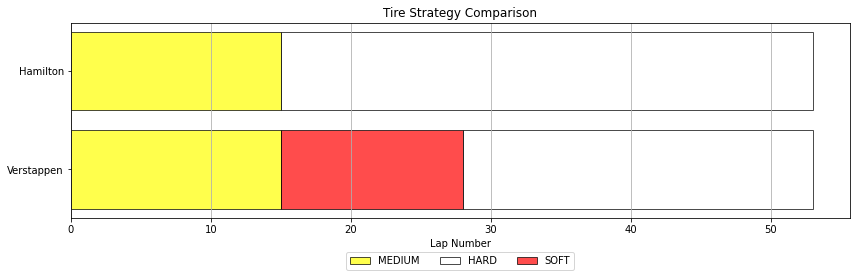

In [24]:
def plot_tire_strategy(hamilton_strategy, verstappen_strategy):
    plt.figure(figsize=(12, 4))
    
    # Define color map for tire compounds
    compound_colors = {'SOFT': 'red', 'MEDIUM': 'yellow', 'HARD': 'white'}
    
    # Plot Hamilton's strategy
    y_hamilton = 1
    for stint in hamilton_strategy['stints']:
        plt.barh(y_hamilton, stint['laps'], left=stint['start_lap'] - 1, 
                 color=compound_colors[stint['compound']], alpha=0.7, 
                 edgecolor='black', label=stint['compound'])
    
    # Plot Verstappen's strategy
    y_verstappen = 0
    for stint in verstappen_strategy['stints']:
        plt.barh(y_verstappen, stint['laps'], left=stint['start_lap'] - 1, 
                 color=compound_colors[stint['compound']], alpha=0.7, 
                 edgecolor='black', label=stint['compound'])
    
    plt.yticks([0, 1], ['Verstappen', 'Hamilton'])
    plt.xlabel('Lap Number')
    plt.title('Tire Strategy Comparison')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper center', 
               bbox_to_anchor=(0.5, -0.15), ncol=3)
    
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

plot_tire_strategy(hamilton_strategy, verstappen_strategy)

# Plotting Tire Compound Usage

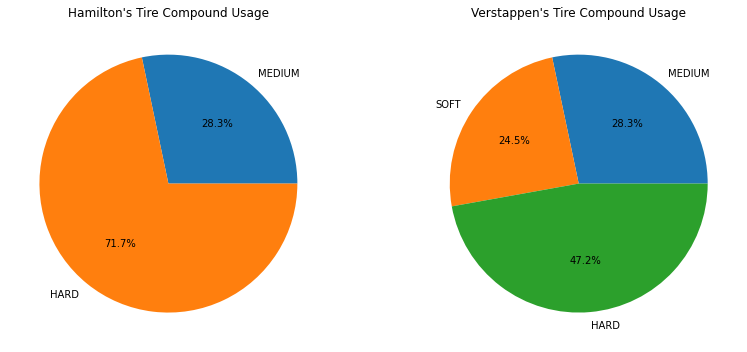

In [25]:
def plot_tire_compound_usage(hamilton_strategy, verstappen_strategy):
    plt.figure(figsize=(12, 5))
    
    hamilton_compounds = [stint['compound'] for stint in hamilton_strategy['stints']]
    hamilton_laps = [stint['laps'] for stint in hamilton_strategy['stints']]
    verstappen_compounds = [stint['compound'] for stint in verstappen_strategy['stints']]
    verstappen_laps = [stint['laps'] for stint in verstappen_strategy['stints']]
    
    plt.subplot(1, 2, 1)
    plt.pie(hamilton_laps, labels=hamilton_compounds, autopct='%1.1f%%')
    plt.title("Hamilton's Tire Compound Usage")
    
    plt.subplot(1, 2, 2)
    plt.pie(verstappen_laps, labels=verstappen_compounds, autopct='%1.1f%%')
    plt.title("Verstappen's Tire Compound Usage")
    
    plt.tight_layout()
    plt.show()

def plot_pit_stop_strategy(hamilton_strategy, verstappen_strategy):
    plt.figure(figsize=(10, 6))
    
    hamilton_pits = len(hamilton_strategy['stints']) - 1
    verstappen_pits = len(verstappen_strategy['stints']) - 1
    
    plt.bar(['Hamilton', 'Verstappen'], [hamilton_pits, verstappen_pits])
    plt.title('Number of Pit Stops')
    plt.ylabel('Number of Stops')
    
    for i, v in enumerate([hamilton_pits, verstappen_pits]):
        plt.text(i, v, str(v), ha='center', va='bottom')
    
    plt.show()

def plot_track_temp_vs_compound(hamilton_strategy, verstappen_strategy, conditions):
    plt.figure(figsize=(12, 6))
    
    track_temps = conditions['track_temps']
    laps = list(track_temps.keys())
    temps = list(track_temps.values())

    plt.plot(laps, temps, label='Track Temperature', color='gray')
    
    compound_colors = {'SOFT': 'red', 'MEDIUM': 'yellow', 'HARD': 'white'}
    
    for stint in hamilton_strategy['stints']:
        plt.axvspan(stint['start_lap'], stint['start_lap'] + stint['laps'], 
                    alpha=0.3, color=compound_colors[stint['compound']], 
                    label=f"Hamilton {stint['compound']}")
    
    for stint in verstappen_strategy['stints']:
        plt.axvspan(stint['start_lap'], stint['start_lap'] + stint['laps'], 
                    alpha=0.3, color=compound_colors[stint['compound']], 
                    hatch='///', label=f"Verstappen {stint['compound']}")
    
    plt.title('Track Temperature vs. Tire Compound Choice')
    plt.xlabel('Lap Number')
    plt.ylabel('Track Temperature (°C)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

plot_tire_compound_usage(hamilton_strategy, verstappen_strategy)

# Plotting Tire Degradation Comparison

This was done using a simplified degradation model due to lack of data available

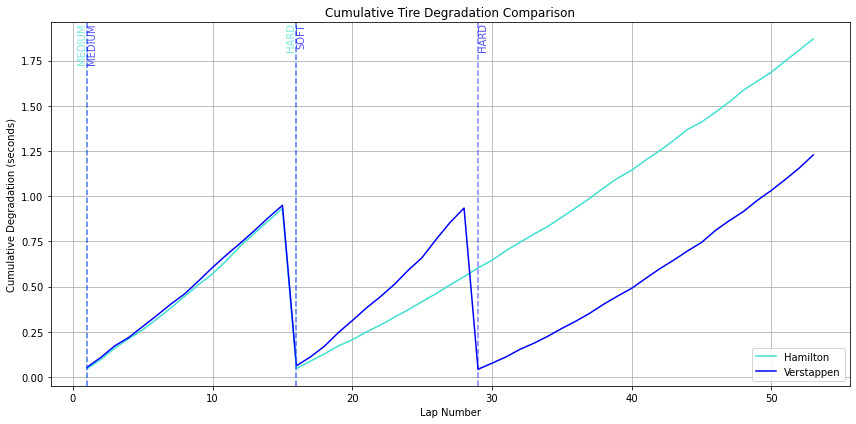

In [26]:
def simulate_tire_degradation(compound, laps, base_deg_rate):
    compound_factors = {'SOFT': 1.2, 'MEDIUM': 1.0, 'HARD': 0.8}
    degradation = np.zeros(laps)
    for lap in range(laps):
        lap_factor = 1 + (lap / laps) * 0.5
        random_factor = norm.rvs(loc=1, scale=0.1)
        deg_rate = base_deg_rate * compound_factors[compound] * lap_factor * random_factor
        degradation[lap] = deg_rate
    return np.cumsum(degradation)

def plot_tire_degradation_comparison(hamilton_strategy, verstappen_strategy):
    plt.figure(figsize=(12, 6))
    
    base_deg_rate = 0.05
    
    hamilton_deg = []
    verstappen_deg = []
    hamilton_compounds = []
    verstappen_compounds = []
    
    for stint in hamilton_strategy['stints']:
        stint_deg = simulate_tire_degradation(stint['compound'], stint['laps'], base_deg_rate)
        hamilton_deg.extend(stint_deg)
        hamilton_compounds.extend([stint['compound']] * stint['laps'])
    
    for stint in verstappen_strategy['stints']:
        stint_deg = simulate_tire_degradation(stint['compound'], stint['laps'], base_deg_rate)
        verstappen_deg.extend(stint_deg)
        verstappen_compounds.extend([stint['compound']] * stint['laps'])
    
    laps = range(1, len(hamilton_deg) + 1)
    plt.plot(laps, hamilton_deg, label='Hamilton', color='turquoise')
    plt.plot(laps, verstappen_deg, label='Verstappen', color='blue')
    
    for i, compound in enumerate(hamilton_compounds):
        if i == 0 or compound != hamilton_compounds[i-1]:
            plt.axvline(x=i+1, color='turquoise', linestyle='--', alpha=0.5)
            plt.text(i+1, plt.ylim()[1], compound, rotation=90, va='top', ha='right', color='turquoise', alpha=0.7)
    
    for i, compound in enumerate(verstappen_compounds):
        if i == 0 or compound != verstappen_compounds[i-1]:
            plt.axvline(x=i+1, color='blue', linestyle='--', alpha=0.5)
            plt.text(i+1, plt.ylim()[1], compound, rotation=90, va='top', ha='left', color='blue', alpha=0.7)
    
    plt.title('Cumulative Tire Degradation Comparison')
    plt.xlabel('Lap Number')
    plt.ylabel('Cumulative Degradation (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_tire_degradation_comparison(hamilton_strategy, verstappen_strategy)

### Key Observations: Hamilton vs Verstappen Tire Degradation

### 1. Contrasting Pit Stop Strategies
- **Hamilton**: One-stop strategy (MEDIUM → HARD)
- **Verstappen**: Two-stop strategy (MEDIUM → SOFT → HARD)

### 2. Degradation Patterns
- **Hamilton**:
  - Steady, consistent degradation curve
  - Higher cumulative degradation by race end
- **Verstappen**:
  - More varied degradation rates across stints
  - Lower overall degradation

### 3. Compound-Specific Degradation
- **SOFT tires** (Verstappen's middle stint):
  - Steepest degradation curve
  - Provides performance advantage at cost of durability
- **HARD tires**:
  - Both drivers show slower degradation rate
  - Hamilton's extended HARD stint demonstrates consistent but gradually increasing wear

### 4. Strategic Trade-offs
- **Hamilton**: Minimizes time lost to pit stops, but faces higher tire wear in final laps
- **Verstappen**: More frequent "resets" in degradation, potentially maintaining better tire performance throughout the race

### 5. Crossover Points
- Around lap 28, Hamilton's cumulative degradation surpasses Verstappen's
- This coincides with Verstappen's second pit stop, highlighting the potential performance advantage of fresher tires

### 6. End-of-Race Scenario
- Hamilton enters final laps with significantly higher cumulative degradation
- Verstappen's tires are fresher, potentially allowing for a stronger finish

### 7. Strategic Flexibility
- Verstappen's strategy allows for more adaptability to race conditions
- Hamilton's strategy relies heavily on consistent performance of HARD tires